# Mushrooms Dataset Classification

This is a fun project to apply the Exploratory Data Analysis (EDA) process and numerous classification algorithms on the [Mushrooms dataset from Kaggle](https://www.kaggle.com/datasets/uciml/mushroom-classification), which consists of 8143 data observations of mushrooms and 23 features that describe two classes of mushrooms - edible, and poisonous. I perform Exploratory Data Analysis on the dataset, and apply numerous classification algorithms to choose the best model for predicting whether a mushroom is edible or poisonous. Scroll to the end for a in-depth discussion and conclusion!

You can also find this notebook on my [Github](https://github.com/awesomecosmos/Mushroom-Classification), and on [Kaggle](https://www.kaggle.com/code/theawesomecosmos/will-this-mushroom-be-poisonous-or-not).

In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import plot_roc_curve, auc 
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

We will start by defining some functions which will come in handy later.

In [2]:
def model_predictions(model, X_train, X_test, y_train, y_test, df, model_name):
    """Function to fit model to training data and generate predictions. 
    Another function, performance_metrics_recorder, is called to record the results
    of the predictions to a dataframe for later analysis.

    Args:
        model (instance): An instance of a classifier model.
        X_train (pd.DataFrame): Dataframe containing training data for all columns except target.
        X_test (pd.DataFrame): Dataframe containing testing data for all columns except target.
        y_train (pd.DataFrame): Dataframe containing training data for target column.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.

    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df, model_confusion = performance_metrics_recorder(predictions, y_test, df, model_name)

    return (model, df, model_confusion)

def performance_metrics_recorder(predictions, y_test, df, model_name):
    """Helper function to record scores for model predictions in a DataFrame.

    Args:
        predictions (pd.DataFrame): Dataframe of predictions generated by classifier.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.
    
    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model_accuracy_score = accuracy_score(y_test, predictions)
    model_precision_score = precision_score(y_test, predictions)
    model_recall_score = recall_score(y_test, predictions)
    model_f1_score = f1_score(y_test, predictions)
    model_roc_auc = roc_auc_score(y_test, predictions)
    model_confusion = confusion_matrix(y_test, predictions)

    df.loc[len(df)] = [model_name,model_accuracy_score,model_precision_score,model_recall_score,model_f1_score,model_roc_auc]

    return(df, model_confusion)

def feature_importance_visualizer(X, model, label, color=None, grid=None):
    """Helper function to visualize feature importance.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    features_list = X.columns.values
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure()
    plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx], align='center', color=color)
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

def feature_importance_visualizer_for_nonstandards(X, model, label, color, grid=None):
    """Helper function to visualize feature importance for algorithms that do 
    not support the model.feature_importances_ method.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    try:
        importance = model.coef_[0]
    except:
        importance = model.coef_

    feature_importances = pd.DataFrame({
        'feature':X.columns.to_list(), 
        'importance':importance.tolist()
    }).sort_values('importance',ascending=True)

    plt.barh(feature_importances['feature'],feature_importances['importance'], align='center', color=color)
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

## Step One: Data Exploration, Analysis and Pre-Processing

In this section, we explore the raw dataset and clean it for later use.

In [3]:
# reading the raw CSV data file
df = pd.read_csv("data/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
# finding columns in the df which have any null/na values
np.where(pd.isna(df))

(array([], dtype=int64), array([], dtype=int64))

In [5]:
# Checking the missing values
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

We find that this is a rare perfect dataset with no NA or null values.

In [6]:
# getting the shape of the dataset
df.shape

(8124, 23)

We also note that there are 23 columns (i.e. features), and 8124 rows of data.

In [7]:
# getting info on the columns of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [8]:
# getting statistical descriptions of the df
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [9]:
# getting unique values from each column, so we know which values to convert to numerical
for col in df.columns:
    print(col,df[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


We noted the column names, their data types, and the number of unique values for each feature. We see that they are all object data types, i.e. strings, and have several distinct values. We will need to convert these strings to a numerical data type. Let's perform label encoding on these features for simplicity.

In [10]:
# creating a copy of the original dataframe
df2 = df.copy()

In [11]:
# performing Label Encoding on each of the 23 features
for col in df2.columns:
    le = LabelEncoder()
    le.fit(df2[col])
    df2[col] = le.transform(df2[col])
    if col == 'class':
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)

{'e': 0, 'p': 1}


So we learn that the LabelEncoding method has encoded class 'edible' to 0, and 'poisonous' to 1. Good to know for future reference!

In [12]:
# check to see counts for each class
counts = df2['class'].value_counts()
print(counts)

0    4208
1    3916
Name: class, dtype: int64


In [13]:
# checking ratio of class 'e' vs 'p'
total_counts = 4208 + 3916
print((4208/total_counts)*100) # class 0 = 'e'
print((3916/total_counts)*100) # class 1 = 'p'

51.7971442639094
48.20285573609059


The data seems balanced - there is very roughly a 50-50 ratio for both edible and poisonous mushrooms, which indicates our data is balanced. Therefore, we won't apply balancing methods like SMOTE here.

In [14]:
# examining the label-encoded dataframe
df2.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


Now that the dataframe is in a numerical format, we can perform some more Exploratory Data Analysis (EDA). Let's start by visualizing the correlation of the features to each other.

In [15]:
# getting correlation matrix of matrix
corr = df2.corr()
corr.style.background_gradient('coolwarm')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


In [16]:
# checking the veil-type column, which has nan
df2['veil-type'].unique()

array([0])

It seems that the 'nan' in the correlation matrix for the veil-type column is because the label for that column has been encoded as 0. Looking back at the original data, it seems that there is only one value for veil-type, 'p', which has been encoded to 0. This may or may not be a problem later, only time will tell.

In [17]:
# standardizing the data
df3 = df2.copy()
scaler = StandardScaler()
df3 = scaler.fit_transform(df3)
df3 = pd.DataFrame(df3, columns=df2.columns)

In [18]:
# getting correlation matrix of standardized matrix
corr = df3.corr()
corr.style.background_gradient('coolwarm')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


## Step Two: Classification Models

We start by splitting the dataset into two distinct sets, X - which contains all the features except for the target feature ('class'), and Y - which only contains the target feature ('class'), and creating train/test splits by an 80/20% split ratio.

In [19]:
# splitting dataset
X = df2.drop(['class'],axis=1)
Y = df2['class']

In [20]:
# creating train/test split using 80% data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [21]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1","roc_auc"]
performance_metrics = pd.DataFrame(columns=column_names)

Now we will use some models and classify the data.

In [22]:
# Naive Bayes
nb = GaussianNB()
nb, performance_metrics, nb_confusion = model_predictions(nb, X_train, X_test, y_train, y_test, performance_metrics, "Naive Bayes")

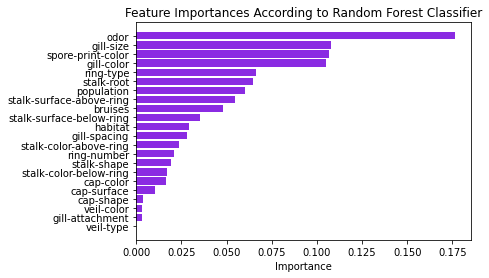

In [23]:
# Random Forest
label = "Random Forest"
rf = RandomForestClassifier(random_state=42)
rf, performance_metrics, rf_confusion = model_predictions(rf, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, rf, label, color="blueviolet")

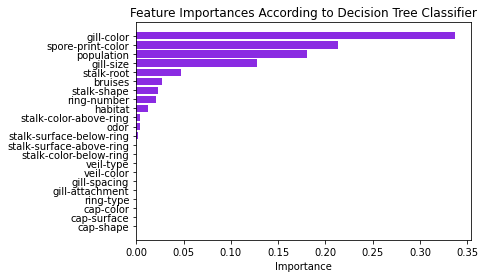

In [24]:
# Decision Tree
label = "Decision Tree"
dt = tree.DecisionTreeClassifier()
dt, performance_metrics, dt_confusion = model_predictions(dt, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, dt, label, color="blueviolet")

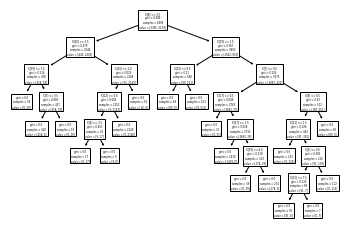

In [25]:
# also plotting decision tree
tree.plot_tree(dt);

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


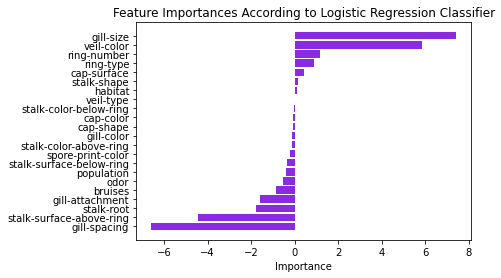

In [26]:
# Logistic Regression
label = "Logistic Regression"
lr = LogisticRegression()
lr, performance_metrics, lr_confusion = model_predictions(lr, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, lr, label, color="blueviolet");

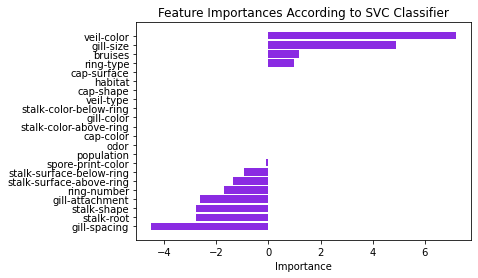

In [27]:
# Support Vector Classifier
label = "SVC"
svc = SVC(kernel='linear')
svc, performance_metrics, svc_confusion = model_predictions(svc, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, svc, label, color="blueviolet")

In [28]:
# K Neighbours
label = "KNN"
knn = KNeighborsClassifier()
knn, performance_metrics, knn_confusion = model_predictions(knn, X_train, X_test, y_train, y_test, performance_metrics, label)
# feature importance function not defined for KNN algorithm

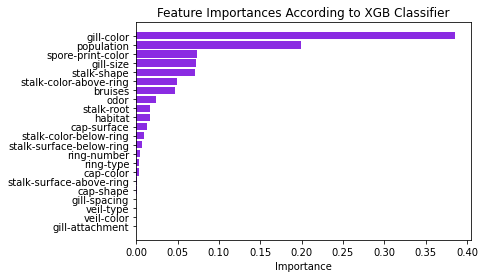

In [29]:
# XGBoost
label = "XGB"
xgboost = xgb.XGBClassifier()
xgboost, performance_metrics, xgb_confusion = model_predictions(xgboost, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, xgboost, label, color="blueviolet")

In [30]:
# examining metrics dataframe
performance_metrics

,method,accuracy,precision,recall,f1,roc_auc
0,Naive Bayes,0.921846,0.909887,0.929668,0.919671,0.922129
1,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
2,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.947077,0.942748,0.947570,0.945153,0.947095
4,SVC,0.972923,0.981723,0.961637,0.971576,0.972515
5,KNN,0.996308,0.992386,1.000000,0.996178,0.996441
6,XGB,1.000000,1.000000,1.000000,1.000000,1.000000


/var/folders/mm/6lyr9rbs7vd53tnvwt0676zm0000gn/T/ipykernel_69318/4285751722.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


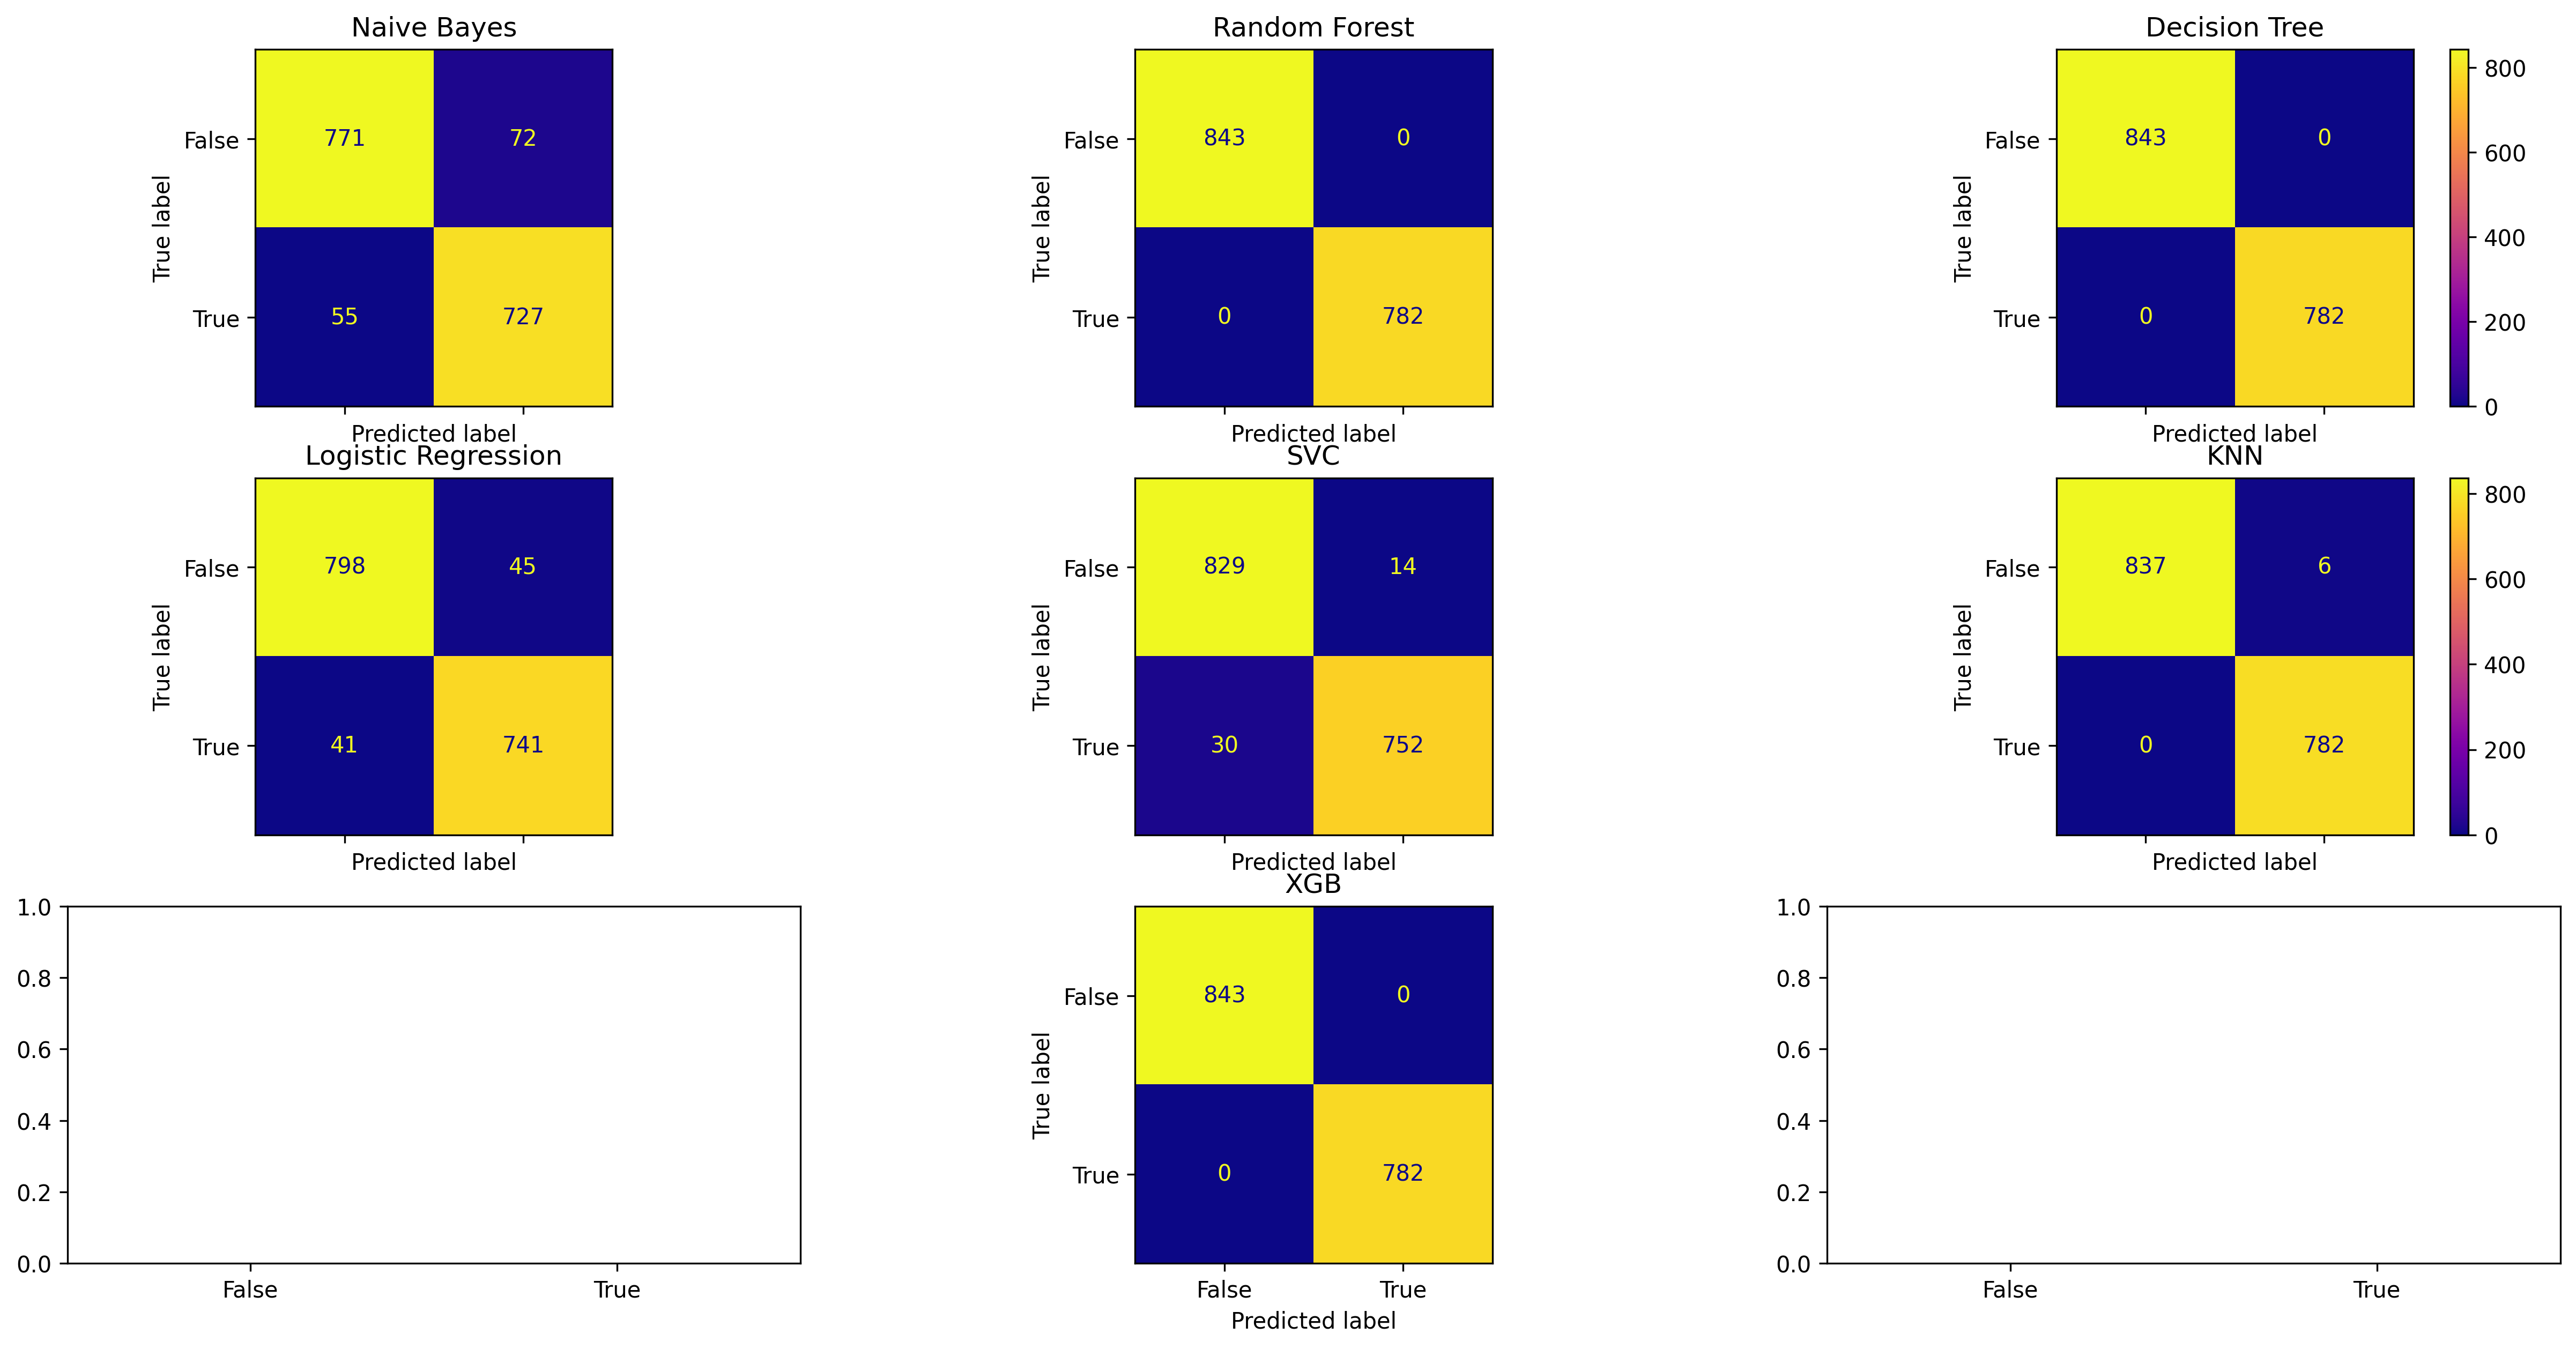

In [31]:
# comparing confusion matrices for this stage of analysis
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))

fig, ax = plt.subplots(3,3,sharex=True, sharey=False, figsize=(20, 10), dpi=300)

# first row
ax[0, 0].set_title(x_labels[0])
ax[0, 1].set_title(x_labels[1])
ax[0, 2].set_title(x_labels[2])
# second row
ax[1, 0].set_title(x_labels[3])
ax[1, 1].set_title(x_labels[4])
ax[1, 2].set_title(x_labels[5])
# third row
ax[2, 1].set_title(x_labels[6])

# first row
ConfusionMatrixDisplay(nb_confusion,display_labels=[False,True]).plot(ax=ax[0, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_confusion,display_labels=[False,True]).plot(ax=ax[0, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(dt_confusion,display_labels=[False,True]).plot(ax=ax[0, 2],cmap='plasma',colorbar=True)
# second row
ConfusionMatrixDisplay(lr_confusion,display_labels=[False,True]).plot(ax=ax[1, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(svc_confusion,display_labels=[False,True]).plot(ax=ax[1, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(knn_confusion,display_labels=[False,True]).plot(ax=ax[1, 2],cmap='plasma',colorbar=True)
# third row
ConfusionMatrixDisplay(xgb_confusion,display_labels=[False,True]).plot(ax=ax[2, 1],cmap='plasma',colorbar=False)
fig.show()

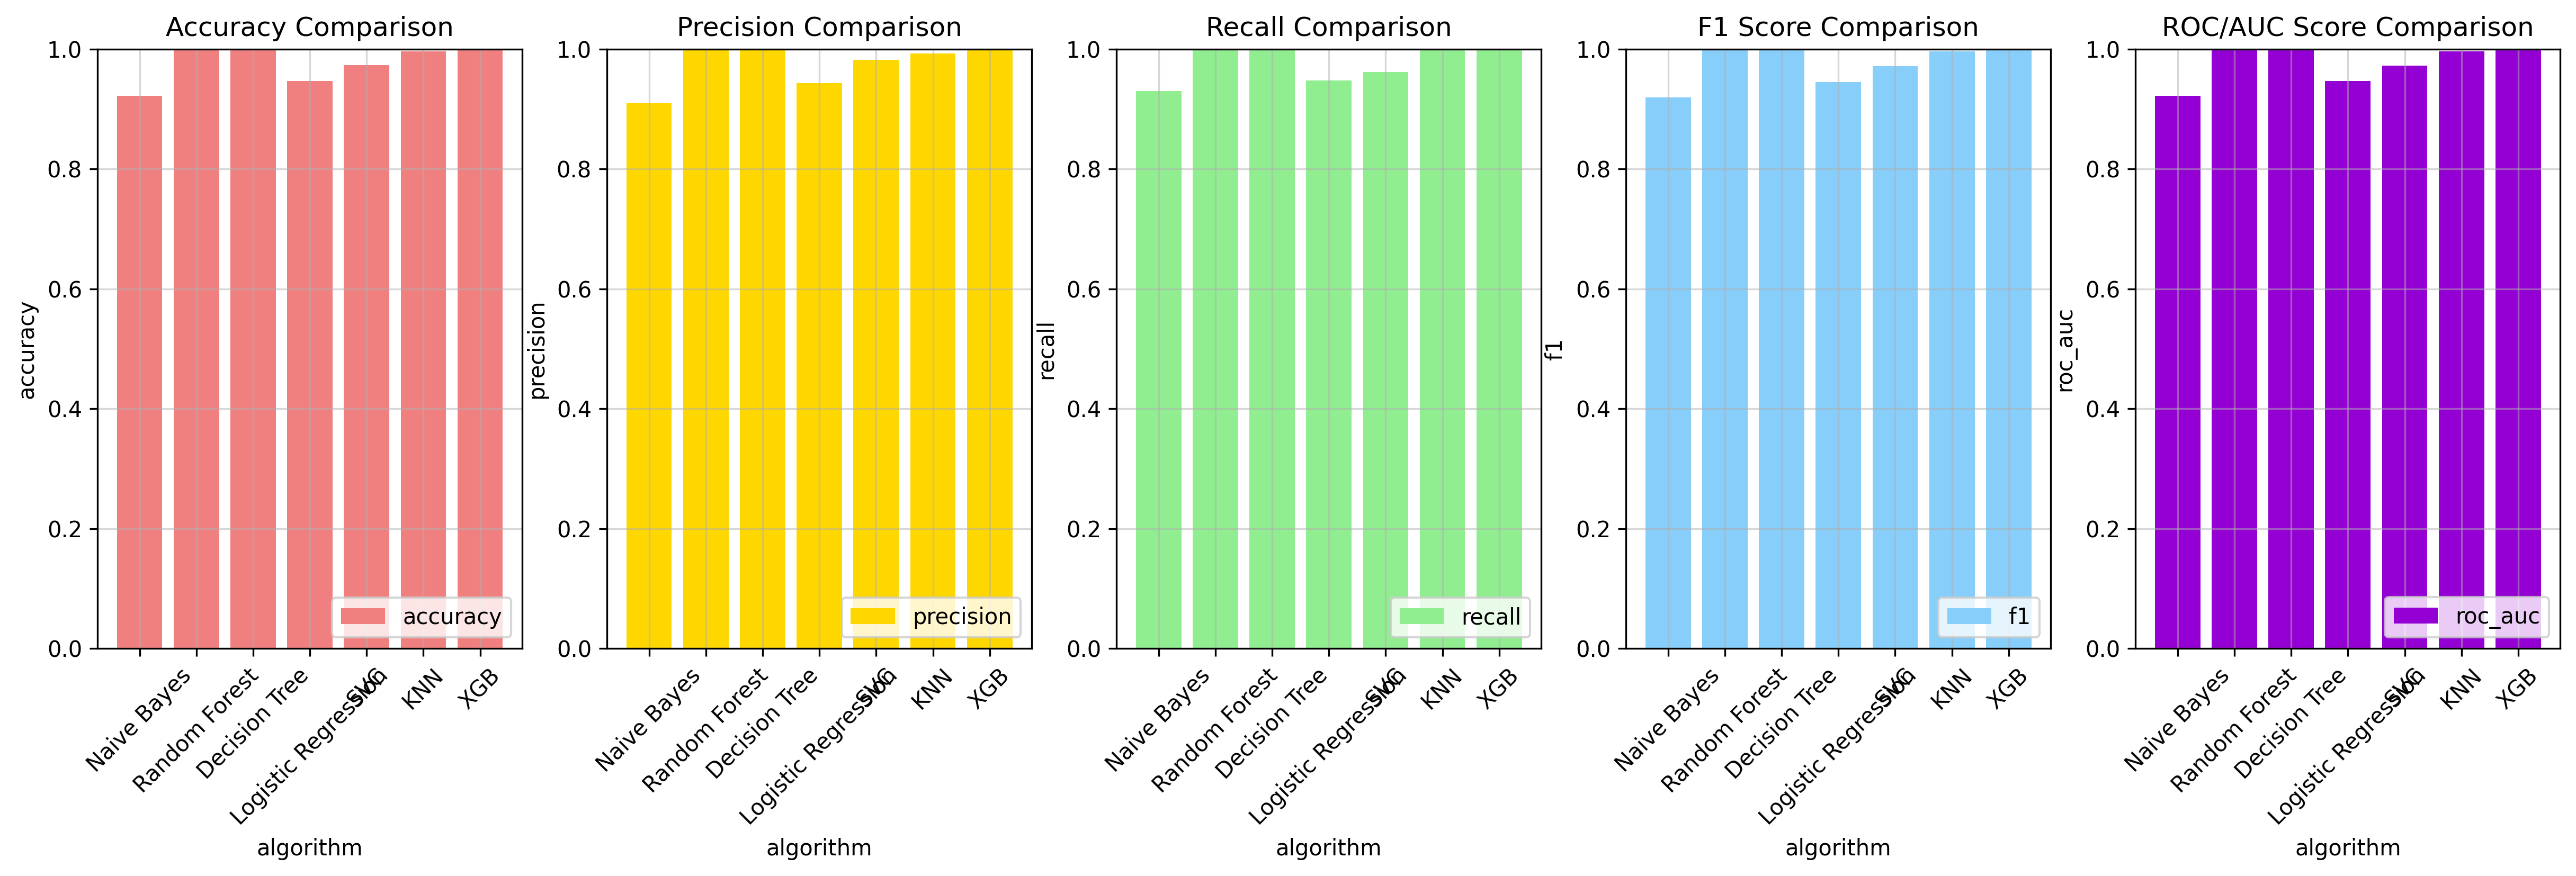

In [32]:
# comparing all metrics
fig, ax = plt.subplots(1, 5, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))
width = 0.3

#row=0, col=0
ax[0].bar(indices,performance_metrics['accuracy'],color="lightcoral",alpha=1,label="accuracy") 
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,performance_metrics['precision'],color="gold",alpha=1,label="precision") 
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,performance_metrics['recall'],color="lightgreen",alpha=1,label="recall") 
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,performance_metrics['f1'],color="lightskyblue",alpha=1,label="f1") 
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

#row=0, col=4
ax[4].bar(indices,performance_metrics['roc_auc'],color="darkviolet",alpha=1,label="roc_auc") 
ax[4].grid(True,alpha=0.5)
ax[4].set_ylim(0,1)
ax[4].set_xlabel("algorithm")
ax[4].set_ylabel("roc_auc")
ax[4].set_title("ROC/AUC Score Comparison")
ax[4].legend(loc='lower right')
ax[4].set_xticks(indices, x_labels, rotation=45)

fig.savefig("img/metrics.jpeg",dpi=300)

<Figure size 3000x1500 with 0 Axes>

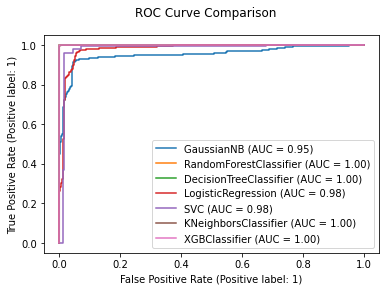

In [33]:
# plotting ROC curves with AUC scores
fig = plt.figure(figsize=(10, 5), dpi=300)
fig = plot_roc_curve(nb, X_test, y_test)
fig = plot_roc_curve(rf, X_test, y_test, ax = fig.ax_)
fig = plot_roc_curve(dt, X_test, y_test, ax = fig.ax_)
fig = plot_roc_curve(lr, X_test, y_test, ax = fig.ax_)
fig = plot_roc_curve(svc, X_test, y_test, ax = fig.ax_)
fig = plot_roc_curve(knn, X_test, y_test, ax = fig.ax_)
fig = plot_roc_curve(xgboost, X_test, y_test, ax = fig.ax_)
fig.figure_.suptitle("ROC Curve Comparison")
plt.show()

## Discussion and Conclusion

For this project, our aim is to find the best possible algorithm which classifies a mushroom as either edible or poisonous. We used 7 algorithms and evailuated their performances. Now we will discuss a few evaluation metrics to judge the best algorithm that should be used to predict mushroom classifications. But first, some terminology! Most evaluation metrics are defined in terms of positives and negatives, as seen in the confusion matrices. In our confusion matrix for our binary classification problem, a positive is defined as 1, which corresponds to poisonous mushrooms. Therefore, the negative class corresponds to 0, which are edible mushrooms. This tells us that our models are finding which mushrooms are poisonous (which is the hypothesis), rather than the other way round. Therefore, here is some more terminology before we define the evaluation metrics:

- TP (True Positives): how many data points were correctly classified as poisonous (actual = 'p', predicted = 'p').
- FP (False Positives): how many data points were incorrectly classified as poisonous (actual = 'e', predicted = 'p').
- FN (False Negatives): how many data points were incorrectly classified as edible (actual = 'p', predicted = 'e').
- TN (True Negatives): how many data points were correctly classified as edible (actual = 'e', predicted = 'e').

**Accuracy**
Accuracy is defined as follows: $\frac{TP+TN}{TP+TN+FP+FN}$

- The accuracy metric is good for a balanced dataset (which we have), and for when every class is important.

**Precision**
Precision is defined as follows: $\frac{TP}{TP+FP}$

- The precision metric is good for measuring how often class 'p' is indeed classified as class 'p', i.e. maximizing on TPs. 
- In our case, this is a good metric to compare our models on, since we need to correctly predict poisonous mushrooms as poisonous, instead of edible, since it can lead to bad things for humans!

**Recall**
Recall is defined as follows: $\frac{TP}{TP+FN}$

- The recall metric is good for measuring how often class 'e' is indeed classified as class 'e', i.e. maximizing TNs.
- This is also a good metric to compare our models, since we also want correctly-classified edible mushrooms!

**F1 Score**
F1 Score is defined as follows: $2\times \frac{precision\times recall}{precision + recall}$

- The F1 metric is referred to as a 'harmonic mean between precision and recall'. 
- This means that it is a good metric to measure how often edible mushrooms and poisonous mushrooms are each correctly classified.

**ROC/AUC Score**
- The ROC (Receiver Operating Characteristic) curve is a graph of the TP rate vs the FP rate.
- The AUC (Area Under Curve) score is a measure of the area under the ROC curve.
- The ROC/AUC score is good for measuring the probability of good predictions made for both edible and poisonous mushrooms.


After looking at all these metrics, we will define our primary metric as precision, since we are interested in minimizing the chance of eating poisonous mushrooms, which will only happen if most of the poisonous samples in the dataset are correctly classified.

One more thing before we start evaluating our models - we note that a few algorithms provided 100% on each metric. This shows that these models have likely overfitted, i.e. the model learned specific rules from the training data and was able to apply those to the testing dataset as-is. We will disregard these overfitted models (Random Forest, Decision Tree, K-Nearest Neighbours, and XGBoost) for final evaluation.

Ok, now we have enough background to start evaluating our models. Once more, let's look at the performance metrics table, after filtering out the overfitted models, based on accuracy.

In [34]:
performance_metrics[performance_metrics['accuracy']!=1].sort_values('precision', ascending=False)

,method,accuracy,precision,recall,f1,roc_auc
5,KNN,0.996308,0.992386,1.000000,0.996178,0.996441
4,SVC,0.972923,0.981723,0.961637,0.971576,0.972515
3,Logistic Regression,0.947077,0.942748,0.947570,0.945153,0.947095
0,Naive Bayes,0.921846,0.909887,0.929668,0.919671,0.922129


Based on our primary metric, precision, we find that the KNN model has performed the best, followed by SVC (linear kernel), followed by logistic regression. The least precise model was Naive Bayes. The KNN model provided 99% precision, SVC provided 98% precision, logistic regression provided 94% precision, and finally Naive Bayes provided 90% precision. This indicates that the KNN model classified 99% of all poisonous mushrooms as poisonous.

We find that the other metrics also have similar performances, with KNN performing the best, followed by SVC, then logistic regression, then Naive Bayes. However, in terms of recall, we find that KNN has 100% recall, which shows that it correctly classified 100% of edible mushrooms as edible. Interesting!

**Based on the extensive analysis performed and comparison of metrics, we will conclude that a K-Nearest Neighbours algorithm, or a Support Vector Classifier model should be used to classify this dataset.**

So then what are the features that make a mushrooms poisonous anyway? According to the SVC model, the **top features that contribute to a mushroom being poisonous are its veil color, gill size, bruises, and the ring type**. The features that contributed least to the classification include gill spacing, stalk root, stalk shape, gill attachment, and ring number, just to name a few.

Therefore, to conclude this analysis, if I had an algorithm with me while I was in the forest exploring mushrooms that told me the likelihood of a mushroom being poisonous or not, I would go with either the KNN algorithm, or the SVC algorithm. I would also pay close attention to the veil color, gill size, bruises, and ring type of the mushrooms to corroborate the algorithm's predictions. ¯/\_(ツ)_/¯